In [1]:
# Stochastic Gradient Descent
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [2]:
import numpy as np
a = np.array([1,2,3,4,5,6])
a = a.reshape(2,3)
print(a)
b = np.array([2,3,4,5,6,7])
b = b.reshape(2,3)
p = {}
p['p1'] = a
p['p2'] = b
print(p)
for key, val in p.items():
    print(val)

[[1 2 3]
 [4 5 6]]
{'p1': array([[1, 2, 3],
       [4, 5, 6]]), 'p2': array([[2, 3, 4],
       [5, 6, 7]])}
[[1 2 3]
 [4 5 6]]
[[2 3 4]
 [5 6 7]]


In [3]:
# Momentum
# v <- αV - η*dL/dW
# W <- W + v
# vは速度, -η*dL/dWが加速度
# 勾配がきつい所ほど、更新の値が大きい
# α 減速項

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [4]:
# AdaGrad
# learning rate decay 徐々に学習係数を小さくする
# 学習係数を全体で一括して下げるのではなく、一つ一つのパラメータに対して個々で減衰させる
# h <- dL/dW ⦿ dL/dW ※⦿は要素毎の掛け算 つまりhは勾配の２乗和を加算したもの
# W <- W - (η/√h) * dL/dW
# hは学習が進むに連れて、大きくなるが逓減する
# 1/√hはh=0で無限大、hが増加するに連れて小さくなる

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [5]:
# Adam ≒　Momentum + AdaGrad
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        self.h = 1e-7 # ゼロ割防止の為の微小値

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key, val in params.items():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + self.h)

In [6]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        self.e = 1e-7 # ゼロ割を防ぐための微小値

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1.0 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + self.e)

In [7]:
class Nesterov:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.v[key]
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1.0 + self.momentum) * self.lr * self.v[key]

In [8]:
def sigmoid(x):
    return 1 / (1.0 + np.exp(-x))

class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, z):
        out = 1 / (1 + np.exp(-z))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx    

def relu(x):
    return np.max(0, x)

class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, z):
        self.mask = (z <= 0)
        out = z.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        # Reluレイヤのforward入力とbackward出力は同じ次元
        dout[self.mask] = 0
        return dout

In [10]:
class Tanh:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = np.tanh(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1 - self.out**2)
        return dx

In [11]:
def affine(x, w, b):
    return np.dot(x, w) + b

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW= np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

In [12]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0) # オーバーフロー対策
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    
    x = x - np.max(x) # オーバーフロー対策
    y = np.exp(x) / np.sum(np.exp(x))
    return y

In [13]:
def cross_entropy_error(y, t):
    """
    # 交差エントロピーの入力(softmaxの出力)は1xN
    if y.ndim == 1: # 1サンプルのみのとき
        z = z.reshape(1, z.size) # (*,) -> (1,*)に変更
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    #print("y.shape", y.shape)
    #print("t.shape", t.shape)
    #print("y.size", y.size)
    #print("t.size", t.size)
    # テストデータがラベリングのとき
    if y.size != t.size:
        t_one_hot = np.zeros_like(y, dtype=np.int) # one_hot表現の雛形
        for index in range(batch_size):
            #print('index', index)
            #print('t[index]', t[index])
            t_one_hot[index, int(t[index])] = 1
        t = t_one_hot # 変換
    
    # tをone-hot表現に変換してから交差エントロピーを計算する
    return -np.sum(t * np.log(y)) / batch_size 
    """
    # 以下、サンプル通り
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    #print('t:', t)        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

In [14]:
a = np.array([1])
b = np.array([1,2])
c = np.array([[1,2], [3,4]])
print(a.ndim)
print(b.ndim)
print(c.ndim)

target = np.array([1,2,3,4,5,6])
print(target.ndim)
print(target.shape)
_target = target.reshape(1, target.size)
print(_target.ndim)
print(_target)
print(_target.shape)

1
1
2
1
(6,)
2
[[1 2 3 4 5 6]]
(1, 6)


In [15]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # Softmaxの出力
        self.t = None
        self.x = None
        
    def forward(self, x, t):
        self.t = t
        self.x = x
        self.y = softmax(x)
        
        #print('self.y', self.y.shape)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        
        # テストデータがone-hot-vector表現の場合
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size # サンプル1個あたりの誤差勾配
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
            
        return dx

In [16]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [17]:
from collections import OrderedDict

class MultiLayerNet:
    """
    'relu', 'sigmoid', 'tanh' : activation_func
    'he'or'xavier'or'std' -> [Heの初期値], [Xavierの初期値]
    weight_decay_lambda -> Weight Decay (L2ノルム)の強さ
    """
    def __init__(self, input_size, hidden_size_list, 
                 output_size, activation='relu', 
                 weight_init_std='he', weight_decay_lambda=0):
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}
        
        # 重みの初期化
        self.__init_weight(weight_init_std)
        
        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu, 'tanh': Tanh}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers["Affine" + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            self.layers['Activation_function'+ str(idx)] = activation_layer[activation]()
            
        # 最後のAffineレイヤ
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
        self.last_layer = SoftmaxWithLoss()
        
        
    def __init_weight(self, weight_init_std):
        
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        
        for idx in range(1, len(all_size_list)):
            
            scale = 0.01
            
            if str(weight_init_std).lower() in ('he'):
                scale = np.sqrt(2.0 / all_size_list[idx-1]) # for ReLu
                
            elif str(weight_init_std).lower() in ('xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx-1]) # for Sigmoid
                
            
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])
            
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        #print('pred_y.shape', y.shape)
        #print("yahoo")
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W'+str(idx)]
            # L2ノルムの強さ
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)
            
        return self.last_layer.forward(y, t) + weight_decay
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        
    def numerical_gradient(self, x, t):
        """数値微分(勾配)"""
        
        loss_W = lambda W: self.loss(x, t) # cross_entropy_error + weight_decay
        
        grads = {}
        
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W'+str(idx)] = numerical_gradient(loss_W, self.params['W'+str(idx)])
            grads['b'+str(idx)] = numerical_gradient(loss_W, self.params['b'+str(idx)])
        
        return grads
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t) # 損失関数, 各レイヤのパラメータメモリを設定
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W'+str(idx)] = self.layers['Affine'+str(idx)].dW + \
            self.weight_decay_lambda * self.layers['Affine'+str(idx)].W
            grads['b'+str(idx)] = self.layers['Affine'+str(idx)].db
        
        return grads
        

In [18]:
% matplotlib inline

In [19]:
def smooth_curve(x):
    """
    損失関数を滑らかにするために、用いる
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

In [20]:
import sys, os
import numpy as np
from mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=False)
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [21]:
train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
optimizers['RMSprop'] = RMSprop()
optimizers['Nesterov'] = Nesterov()

In [22]:
# Relu, std
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(activation='relu', 
                                  weight_init_std='std',
                                  input_size=784, 
                                  hidden_size_list=[100, 100, 100, 100],
                                  output_size=10)
    train_loss[key] = []

In [23]:
# トレーニング開始
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    # 100回ごとに誤差を表示
    if i % 100 == 0:
        print("-----" + "iteration:" + str(i) + "-----")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


-----iteration:0-----
SGD:2.302524362960692
Momentum:2.3025240777588807
AdaGrad:2.2999640981935072
Adam:2.3023531935437864
RMSprop:2.2772976743145907
Nesterov:2.3025367268245795
-----iteration:100-----
SGD:2.302131754053977
Momentum:2.3001675063704585
AdaGrad:1.357454040648401
Adam:1.0682957402187525
RMSprop:0.9626813817497627
Nesterov:2.3022215398152532
-----iteration:200-----
SGD:2.300809605058803
Momentum:2.295458156932037
AdaGrad:0.6135090097264528
Adam:0.7312707207302498
RMSprop:0.5622067378510541
Nesterov:2.301141790796538
-----iteration:300-----
SGD:2.300504210496703
Momentum:2.2956088246110538
AdaGrad:0.5007930771677769
Adam:0.6028594741560915
RMSprop:0.4260068423484747
Nesterov:2.3008765665717363
-----iteration:400-----
SGD:2.302695610184995
Momentum:2.3045118338451553
AdaGrad:0.4016062921007635
Adam:0.47212943662434725
RMSprop:0.3285101943244548
Nesterov:2.302647371990007
-----iteration:500-----
SGD:2.3019094413396473
Momentum:2.3019850349524837
AdaGrad:0.38301425178691373
Ad

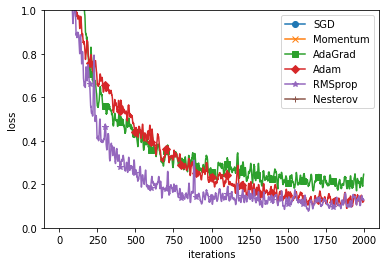

In [24]:
import matplotlib.pyplot as plt
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "*", "Nesterov": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [25]:
# Relu, He
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(activation='relu', weight_init_std='he',\
        input_size=784, hidden_size_list=[100, 100, 100, 100],\
        output_size=10)
    train_loss[key] = []

In [26]:
# トレーニング開始
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    # 100回ごとに誤差を表示
    if i % 100 == 0:
        print("-----" + "iteration:" + str(i) + "-----")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

-----iteration:0-----
SGD:2.328042830759178
Momentum:2.3894388399587934
AdaGrad:2.0326146085840238
Adam:2.3239231623277457
RMSprop:46.49311418836099
Nesterov:2.3719898447284384
-----iteration:100-----
SGD:1.3048267046652358
Momentum:0.4393301439938203
AdaGrad:0.23480703583684137
Adam:0.29848454420814857
RMSprop:0.696450212086014
Nesterov:1.75185083708537
-----iteration:200-----
SGD:0.6320675617495819
Momentum:0.18106710989197394
AdaGrad:0.09910009344844022
Adam:0.18209031027192707
RMSprop:0.11089163865244149
Nesterov:0.9581352872226363
-----iteration:300-----
SGD:0.4034930691359581
Momentum:0.14449142193943695
AdaGrad:0.059861335679613346
Adam:0.12837216776807334
RMSprop:0.1418803486325248
Nesterov:0.6290857570306488
-----iteration:400-----
SGD:0.36163132421369076
Momentum:0.1388071679964237
AdaGrad:0.10695844332261831
Adam:0.07932446458848165
RMSprop:0.16099168060842245
Nesterov:0.4967706990569508
-----iteration:500-----
SGD:0.3982847439194718
Momentum:0.17863746306145117
AdaGrad:0.10

In [ ]:
import matplotlib.pyplot as plt
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "*", "Nesterov": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
# Relu, xavier
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(activation='relu', weight_init_std='xavier',\
        input_size=784, hidden_size_list=[100, 100, 100, 100],\
        output_size=10)
    train_loss[key] = []

In [ ]:
# トレーニング開始
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    # 100回ごとに誤差を表示
    if i % 100 == 0:
        print("-----" + "iteration:" + str(i) + "-----")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

In [ ]:
import matplotlib.pyplot as plt
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "*", "Nesterov": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [31]:
# sigmoid, std
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(activation='sigmoid', weight_init_std='std',\
        input_size=784, hidden_size_list=[100, 100, 100, 100],\
        output_size=10)
    train_loss[key] = []

In [32]:
# トレーニング開始
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    # 100回ごとに誤差を表示
    if i % 100 == 0:
        print("-----" + "iteration:" + str(i) + "-----")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

-----iteration:0-----
SGD:2.304217038789648
Momentum:2.30059702432124
AdaGrad:2.304389855134498
Adam:2.2981477223379354
RMSprop:3.8378469963502932
Nesterov:2.305530012466368
-----iteration:100-----
SGD:2.303383429660132
Momentum:2.3175869060801833
AdaGrad:2.3036441416137974
Adam:2.317353825510047
RMSprop:1.1932313789086786
Nesterov:2.3043025829978894
-----iteration:200-----
SGD:2.2952178206961826
Momentum:2.3020384248431767
AdaGrad:2.2955603626526173
Adam:2.296712216691958
RMSprop:0.656756940093049
Nesterov:2.295314940459174
-----iteration:300-----
SGD:2.3063764686980734
Momentum:2.3056261717490516
AdaGrad:2.3061725820565204
Adam:2.3017872487067335
RMSprop:0.38706732864288007
Nesterov:2.306655244043184
-----iteration:400-----
SGD:2.2960086976830234
Momentum:2.292632579195816
AdaGrad:2.2955291786912695
Adam:2.298936430597185
RMSprop:0.12639102657257176
Nesterov:2.2962611489526346
-----iteration:500-----
SGD:2.2943220411433285
Momentum:2.291864552263447
AdaGrad:2.294549425294089
Adam:2.2

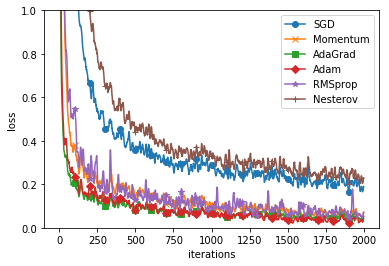

In [27]:
import matplotlib.pyplot as plt
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "*", "Nesterov": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [28]:
# sigmoid, he
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(activation='sigmoid', weight_init_std='he',\
        input_size=784, hidden_size_list=[100, 100, 100, 100],\
        output_size=10)
    train_loss[key] = []

In [29]:
# トレーニング開始
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    # 100回ごとに誤差を表示
    if i % 100 == 0:
        print("-----" + "iteration:" + str(i) + "-----")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

-----iteration:0-----
SGD:2.6619804826678024
Momentum:2.5035514900064353
AdaGrad:2.367364735398765
Adam:2.5235606398612003
RMSprop:4.466779561807405
Nesterov:2.676037359770642
-----iteration:100-----
SGD:2.301415053205167
Momentum:2.3038043645578075
AdaGrad:2.296212199852423
Adam:2.253166108529377
RMSprop:0.8401581759263586
Nesterov:2.298875030426779
-----iteration:200-----
SGD:2.2977914650264335
Momentum:2.298849096961642
AdaGrad:2.293864009452947
Adam:1.8379264040824195
RMSprop:0.14562618212348943
Nesterov:2.297779708062031
-----iteration:300-----
SGD:2.294790034731972
Momentum:2.291397377055031
AdaGrad:2.287120395875923
Adam:1.698924932948513
RMSprop:0.07808474197124067
Nesterov:2.29685951971902
-----iteration:400-----
SGD:2.300106175997909
Momentum:2.2993089258350317
AdaGrad:2.291495096592433
Adam:1.5191853645457618
RMSprop:0.12465496207637844
Nesterov:2.3015299463744583
-----iteration:500-----
SGD:2.2981530729349116
Momentum:2.2926876996873533
AdaGrad:2.2837977345208964
Adam:1.074

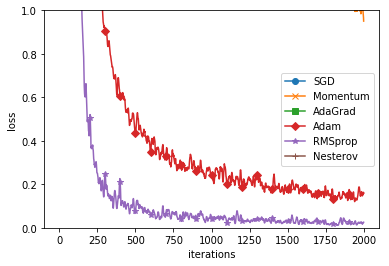

In [228]:
import matplotlib.pyplot as plt
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "*", "Nesterov": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [229]:
# sigmoid, xavier
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(activation='sigmoid', weight_init_std='xavier',\
        input_size=784, hidden_size_list=[100, 100, 100, 100],\
        output_size=10)
    train_loss[key] = []

In [230]:
# トレーニング開始
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    # 100回ごとに誤差を表示
    if i % 100 == 0:
        print("-----" + "iteration:" + str(i) + "-----")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

-----iteration:0-----
SGD:2.446557753472812
Momentum:2.4315879734311006
AdaGrad:2.397578277127918
Adam:2.3509536781627833
RMSprop:5.534578221871868
Nesterov:2.4308753289984057
-----iteration:100-----
SGD:2.3035051718419686
Momentum:2.306512643021544
AdaGrad:2.3018775356881154
Adam:2.309697133932932
RMSprop:2.3020909213856413
Nesterov:2.3007049888769
-----iteration:200-----
SGD:2.30814896731734
Momentum:2.3059169802195023
AdaGrad:2.307945956312216
Adam:2.3046951320222964
RMSprop:2.306802483102909
Nesterov:2.3076289707471958
-----iteration:300-----
SGD:2.294635013253811
Momentum:2.2899772360938266
AdaGrad:2.295628392270329
Adam:2.2816068083999337
RMSprop:1.9431744698755797
Nesterov:2.296210271023946
-----iteration:400-----
SGD:2.288523739639048
Momentum:2.28819301827199
AdaGrad:2.2890254953965314
Adam:2.253060172335789
RMSprop:1.3829749060715684
Nesterov:2.289534789775735
-----iteration:500-----
SGD:2.2983727855455856
Momentum:2.290258798791137
AdaGrad:2.2987106286831906
Adam:1.734158794

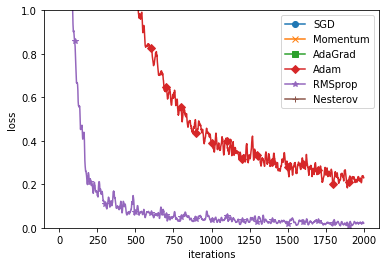

In [30]:
import matplotlib.pyplot as plt
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "*", "Nesterov": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [31]:
# tanh, std
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(activation='tanh', weight_init_std='std',\
        input_size=784, hidden_size_list=[100, 100, 100, 100],\
        output_size=10)
    train_loss[key] = []

In [33]:
# トレーニング開始
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    # 100回ごとに誤差を表示
    if i % 100 == 0:
        print("-----" + "iteration:" + str(i) + "-----")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

-----iteration:0-----
SGD:2.2977896321511437
Momentum:2.2971410409274267
AdaGrad:2.2984929033220403
Adam:0.21709222865368114
RMSprop:2.3067466714587255
Nesterov:2.298093940143217
-----iteration:100-----
SGD:2.2987657692499326
Momentum:2.2987884876445275
AdaGrad:2.2991306779784413
Adam:0.08022962547883072
RMSprop:2.3513359817482136
Nesterov:2.298982187930465
-----iteration:200-----
SGD:2.301487525242444
Momentum:2.302614293258673
AdaGrad:2.301512708262085
Adam:0.09398717849144739
RMSprop:2.291888272180022
Nesterov:2.3014753175533533
-----iteration:300-----
SGD:2.301692078691206
Momentum:2.3014188890714884
AdaGrad:2.3016511488015885
Adam:0.06959468056089971
RMSprop:2.3370795540357974
Nesterov:2.3016693574500624
-----iteration:400-----
SGD:2.3014546773393767
Momentum:2.300533754556517
AdaGrad:2.3015098378812633
Adam:0.10497545762638198
RMSprop:2.3595508341779174
Nesterov:2.301509099229956
-----iteration:500-----
SGD:2.304088490779647
Momentum:2.302847094856073
AdaGrad:2.3038590319548136
A

ValueError: x and y must have same first dimension, but have shapes (2000,) and (4000,)

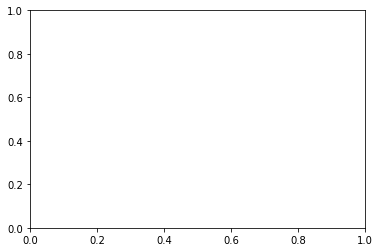

In [34]:
import matplotlib.pyplot as plt
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "*", "Nesterov": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [35]:
# tanh, he
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(activation='tanh', weight_init_std='he',\
        input_size=784, hidden_size_list=[100, 100, 100, 100],\
        output_size=10)
    train_loss[key] = []

In [248]:
# トレーニング開始
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    # 100回ごとに誤差を表示
    if i % 100 == 0:
        print("-----" + "iteration:" + str(i) + "-----")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

-----iteration:0-----
SGD:2.398084086030484
Momentum:2.5540861069471625
AdaGrad:2.29667017057482
Adam:2.1761562064716022
RMSprop:3.941452256927585
Nesterov:2.5640103069358844
-----iteration:100-----
SGD:0.9299415294894029
Momentum:0.41284187510314124
AdaGrad:0.648108144006434
Adam:0.28936751116046344
RMSprop:1.7171233614618717
Nesterov:1.0902395404113516
-----iteration:200-----
SGD:0.6072217873032069
Momentum:0.24084035378778204
AdaGrad:0.3737947193008593
Adam:0.16548913267904242
RMSprop:1.3648825137309983
Nesterov:0.7429038552103018
-----iteration:300-----
SGD:0.5175538750534812
Momentum:0.2345737864746055
AdaGrad:0.33943073941233415
Adam:0.14315365714352643
RMSprop:0.5223393473415954
Nesterov:0.6109349750411996
-----iteration:400-----
SGD:0.5744406354647285
Momentum:0.32269748663087483
AdaGrad:0.48719114015702225
Adam:0.21764933570209039
RMSprop:0.2924424851791861
Nesterov:0.6269114437721383
-----iteration:500-----
SGD:0.48984356489919995
Momentum:0.27315561719952386
AdaGrad:0.351518

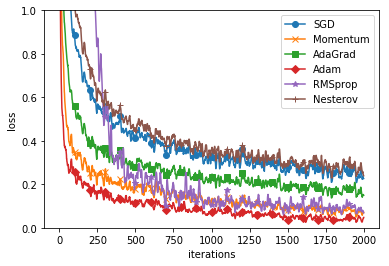

In [249]:
import matplotlib.pyplot as plt
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "*", "Nesterov": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [250]:
# tanh, xavier
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(activation='tanh', weight_init_std='xavier',\
        input_size=784, hidden_size_list=[100, 100, 100, 100],\
        output_size=10)
    train_loss[key] = []

In [251]:
# トレーニング開始
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    # 100回ごとに誤差を表示
    if i % 100 == 0:
        print("-----" + "iteration:" + str(i) + "-----")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

-----iteration:0-----
SGD:2.341772826396543
Momentum:2.3121983411917335
AdaGrad:2.2788846724651775
Adam:2.3462977155258464
RMSprop:2.4350707174840833
Nesterov:2.293153216277248
-----iteration:100-----
SGD:1.4708101997988248
Momentum:0.4105872887542824
AdaGrad:1.0003373749858606
Adam:0.31316498418629407
RMSprop:2.333010166179922
Nesterov:1.6266708556397214
-----iteration:200-----
SGD:0.9218616646522029
Momentum:0.23113259983924592
AdaGrad:0.5696793502177888
Adam:0.1477708160650703
RMSprop:2.369711379695841
Nesterov:1.0758846503030695
-----iteration:300-----
SGD:0.725586379461548
Momentum:0.2570475213725914
AdaGrad:0.5163094007964237
Adam:0.19609684727746857
RMSprop:2.3028138693598046
Nesterov:0.8829876411254757
-----iteration:400-----
SGD:0.6549806388635654
Momentum:0.2715205749375335
AdaGrad:0.46129379381350527
Adam:0.11416519120049026
RMSprop:2.3585130930530576
Nesterov:0.7646392708060443
-----iteration:500-----
SGD:0.5714784571897131
Momentum:0.21177218854687713
AdaGrad:0.39558930123

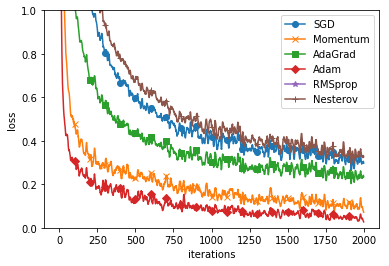

In [252]:
import matplotlib.pyplot as plt
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "*", "Nesterov": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [36]:
# Batch Normalization 強制的にアクティベーション分布に広がりを持たせる方法
# Input -> Affine -> Batch Norm -> Activation -> Affine -> Batch Norm -> Activation -> ... -> Softmax -> Loss
# mean=0.0, var = 1.0になるように正規化
class BatchNormalization:
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # conv層の場合は4次元、全結合の場合は2次元
        
        # テスト時に使用する平均と分散
        self.running_mean = running_mean
        self.running_var = running_var
        
        # backward時に使用する中間データ
        self.dgamma = None
        self.dbeta = None
        self.xc = None
        self.xn = None
        self.std = None
        self.batch_size = None
        
    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        
        # conv層に対処
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)
        
        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape) # 元の次元に戻す
    
    def __forward(self, x, train_flg):
        
        # 学習前の誤差を出す過程
        if self.running_mean is None:
            N, D = x.shape # サンプル数N, 特徴数D
            self.running_mean = np.zeros(D) # D次元ベクトル
            self.running_var = np.zeros(D)
        
        # ゼロ割を防ぐための微小値
        h = 10e-7
        
        if train_flg:
            # 入力データxの正規化(平均0, 分散1)
            mu = np.mean(x, axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + h) # 微小値を入れる
            xn = xc / std # 正規化済み
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            
            # 入力データの時系列的な移動平均と移動分散を計算（1データ＝ミニバッチ）
            self.running_mean = self.momentum * self.running_mean + (1.0 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1.0 - self.momentum) * var
        else:
            # 移動平均と移動分散を使って正規化
            xc = x - self.running_mean
            xn = xc / np.sqrt(self.running_var)
        
        out = self.gamma * xn + self.beta
        
        return out
    
    def backward(self, dout):
        # conv層に対処
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)
            
        dx = self.__backward(dout)
        dx = dx.reshape(*self.input_shape) # *はタプルのアンパック機能
        
        return dx
    
    def __backward(self, dout):
        # 各変数に関する誤差関数の微分を求める
        
        #print('dout', dout)
        #print('self.xn', self.xn)
        
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxc * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dbeta = dbeta
        self.dgamma = dgamma
        
        return dx

In [37]:
class MultiLayerNetExtend:
    """拡張版の全結合による多層NN
    Weight Decay, Dropout, Batch Normalizationの機能を持つ
    
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                activation='relu', weight_init_std='he',
                weight_decay_lambda=0, use_dropout=False,
                dropout_ration=0.5, use_batchnorm=False):
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}
        
        # 重みの初期化
        self.__init_weight(weight_init_std)
        
        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu, 'tanh': Tanh}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num + 1):
            
            # Affineレイヤ
            self.layers['Affine' + str(idx)] = Affine(self.params['W'+str(idx)],
                                                     self.params['b'+str(idx)])
            # BatchNormレイヤ
            if self.use_batchnorm:
                self.params['gamma'+str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta'+str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm'+str(idx)] = BatchNormalization(self.params['gamma'+str(idx)],
                                                                      self.params['beta'+str(idx)])
            
            # Activationレイヤ
            self.layers['Activation_function'+str(idx)] = activation_layer[activation]()
                
            # Dropoutレイヤ
            if self.use_dropout:
                self.layers['Dropout'+str(idx)] = Dropout(dropout_ration)
                
        
        idx = self.hidden_layer_num + 1
        self.layers['Affine'+str(idx)] = Affine(self.params['W'+ str(idx)],
                                               self.params['b'+str(idx)])
        
        self.last_layer = SoftmaxWithLoss()
        
    
    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        scale = 0.01
        for idx in range(1, self.hidden_layer_num + 2):
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1]) # [Heの初期値]
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size__list[idx - 1]) # [Xavierの初期値]
            
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx - 1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])
        
    
    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x
    
    
    def loss(self, x, t, train_flg=False):
        y = self.predict(x, train_flg)
        
        # Weight Decay(荷重減衰)用のL2ノルムを損失関数に追加
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            # 各レイヤのパラメータに対して、L2ノルムを計算して、加算
            W = self.params["W" + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
        return self.last_layer.forward(y, t) + weight_decay
    
    
    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t, train_flg=True)
        
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])            
        return grads
    
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # パラメータの微分値の抽出
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + \
            self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta
        return grads

In [45]:
import sys, os
import numpy as np
from mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=False)
print(x_train.shape)
print(x_test.shape)
print(x_train[0])
print(t_train[0])

(60000, 784)
(10000, 784)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.     

In [39]:
# batch norm gradient check

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100],\
                             output_size=10, use_batchnorm=True)

x_batch = x_train[:1]
t_batch = t_train[:1]

grad_backdrop = network.gradient(x_batch, t_batch)
grad_numerical = network.numerical_gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backdrop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:0.0
b1:0.0
gamma1:0.0
beta1:0.0
W2:0.0
b2:0.0
gamma2:0.0
beta2:0.04889023408995996
W3:0.0
b3:1.2012612848888439e-10


====== 1/16 =====
epoch:0|0.117 - 0.135
epoch:1|0.117 - 0.09
epoch:2|0.117 - 0.127
epoch:3|0.117 - 0.077
epoch:4|0.117 - 0.267
epoch:5|0.117 - 0.23
epoch:6|0.117 - 0.117
epoch:7|0.117 - 0.19
epoch:8|0.117 - 0.122
epoch:9|0.117 - 0.118
epoch:10|0.117 - 0.097
epoch:11|0.117 - 0.111
epoch:12|0.117 - 0.134
epoch:13|0.117 - 0.191
epoch:14|0.117 - 0.157
epoch:15|0.117 - 0.216
epoch:16|0.117 - 0.235
epoch:17|0.117 - 0.172
epoch:18|0.117 - 0.228


No handles with labels found to put in legend.


epoch:19|0.117 - 0.219
train_acc_list [0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117]
bn_train_acc_list [0.135, 0.09, 0.127, 0.077, 0.267, 0.23, 0.117, 0.19, 0.122, 0.118, 0.097, 0.111, 0.134, 0.191, 0.157, 0.216, 0.235, 0.172, 0.228, 0.219]
====== 2/16 =====
epoch:0|0.116 - 0.173
epoch:1|0.116 - 0.062
epoch:2|0.116 - 0.084
epoch:3|0.116 - 0.125
epoch:4|0.116 - 0.199
epoch:5|0.116 - 0.197
epoch:6|0.116 - 0.106
epoch:7|0.116 - 0.073
epoch:8|0.116 - 0.103
epoch:9|0.116 - 0.081
epoch:10|0.116 - 0.178
epoch:11|0.116 - 0.141
epoch:12|0.116 - 0.095
epoch:13|0.116 - 0.104
epoch:14|0.116 - 0.138
epoch:15|0.116 - 0.237
epoch:16|0.116 - 0.265
epoch:17|0.116 - 0.157
epoch:18|0.116 - 0.232
epoch:19|0.116 - 0.207
train_acc_list [0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116]
bn_train_acc_list [0.173, 0.062, 0.084, 0

No handles with labels found to put in legend.


====== 3/16 =====
epoch:0|0.093 - 0.096
epoch:1|0.116 - 0.115
epoch:2|0.116 - 0.103
epoch:3|0.117 - 0.092
epoch:4|0.116 - 0.1
epoch:5|0.116 - 0.149
epoch:6|0.116 - 0.197
epoch:7|0.117 - 0.223
epoch:8|0.117 - 0.253
epoch:9|0.117 - 0.236
epoch:10|0.117 - 0.22
epoch:11|0.117 - 0.225
epoch:12|0.117 - 0.198
epoch:13|0.117 - 0.191
epoch:14|0.117 - 0.179
epoch:15|0.117 - 0.213
epoch:16|0.117 - 0.219
epoch:17|0.117 - 0.235


No handles with labels found to put in legend.


epoch:18|0.117 - 0.223
epoch:19|0.117 - 0.224
train_acc_list [0.093, 0.116, 0.116, 0.117, 0.116, 0.116, 0.116, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117]
bn_train_acc_list [0.096, 0.115, 0.103, 0.092, 0.1, 0.149, 0.197, 0.223, 0.253, 0.236, 0.22, 0.225, 0.198, 0.191, 0.179, 0.213, 0.219, 0.235, 0.223, 0.224]
====== 4/16 =====
epoch:0|0.116 - 0.116
epoch:1|0.116 - 0.082
epoch:2|0.117 - 0.098
epoch:3|0.117 - 0.203
epoch:4|0.117 - 0.084
epoch:5|0.117 - 0.097
epoch:6|0.117 - 0.162
epoch:7|0.117 - 0.148
epoch:8|0.117 - 0.134
epoch:9|0.117 - 0.175
epoch:10|0.117 - 0.228
epoch:11|0.117 - 0.22
epoch:12|0.117 - 0.203
epoch:13|0.117 - 0.19
epoch:14|0.117 - 0.146
epoch:15|0.117 - 0.059
epoch:16|0.117 - 0.162
epoch:17|0.117 - 0.172
epoch:18|0.117 - 0.182


No handles with labels found to put in legend.


epoch:19|0.117 - 0.276
train_acc_list [0.116, 0.116, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117]
bn_train_acc_list [0.116, 0.082, 0.098, 0.203, 0.084, 0.097, 0.162, 0.148, 0.134, 0.175, 0.228, 0.22, 0.203, 0.19, 0.146, 0.059, 0.162, 0.172, 0.182, 0.276]
====== 5/16 =====
epoch:0|0.105 - 0.116
epoch:1|0.116 - 0.098
epoch:2|0.116 - 0.098
epoch:3|0.116 - 0.097
epoch:4|0.117 - 0.096
epoch:5|0.117 - 0.098
epoch:6|0.116 - 0.106
epoch:7|0.116 - 0.237
epoch:8|0.116 - 0.216
epoch:9|0.116 - 0.209
epoch:10|0.116 - 0.23
epoch:11|0.116 - 0.181
epoch:12|0.116 - 0.195
epoch:13|0.116 - 0.206
epoch:14|0.116 - 0.143
epoch:15|0.116 - 0.192
epoch:16|0.116 - 0.254
epoch:17|0.116 - 0.254
epoch:18|0.116 - 0.2
epoch:19|0.116 - 0.198
train_acc_list [0.105, 0.116, 0.116, 0.116, 0.117, 0.117, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116]
bn_train_acc_list [0.116, 0.098, 0.098, 0.0

No handles with labels found to put in legend.


====== 6/16 =====
epoch:0|0.117 - 0.037
epoch:1|0.099 - 0.005
epoch:2|0.116 - 0.127
epoch:3|0.116 - 0.212
epoch:4|0.116 - 0.096
epoch:5|0.116 - 0.097
epoch:6|0.116 - 0.202
epoch:7|0.116 - 0.215
epoch:8|0.116 - 0.225
epoch:9|0.116 - 0.215
epoch:10|0.116 - 0.209
epoch:11|0.116 - 0.21
epoch:12|0.116 - 0.221
epoch:13|0.116 - 0.217
epoch:14|0.116 - 0.221
epoch:15|0.116 - 0.227
epoch:16|0.116 - 0.223
epoch:17|0.116 - 0.231
epoch:18|0.116 - 0.237
epoch:19|0.116 - 0.228
train_acc_list [0.117, 0.099, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116]
bn_train_acc_list [0.037, 0.005, 0.127, 0.212, 0.096, 0.097, 0.202, 0.215, 0.225, 0.215, 0.209, 0.21, 0.221, 0.217, 0.221, 0.227, 0.223, 0.231, 0.237, 0.228]


No handles with labels found to put in legend.


====== 7/16 =====
epoch:0|0.116 - 0.117
epoch:1|0.116 - 0.041
epoch:2|0.116 - 0.083
epoch:3|0.116 - 0.204
epoch:4|0.116 - 0.196
epoch:5|0.116 - 0.252
epoch:6|0.116 - 0.171
epoch:7|0.116 - 0.167
epoch:8|0.117 - 0.158
epoch:9|0.117 - 0.096
epoch:10|0.117 - 0.098
epoch:11|0.116 - 0.043
epoch:12|0.116 - 0.133
epoch:13|0.116 - 0.131
epoch:14|0.116 - 0.154
epoch:15|0.116 - 0.226
epoch:16|0.116 - 0.292
epoch:17|0.116 - 0.227
epoch:18|0.116 - 0.205
epoch:19|0.116 - 0.181
train_acc_list [0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.117, 0.117, 0.117, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116]
bn_train_acc_list [0.117, 0.041, 0.083, 0.204, 0.196, 0.252, 0.171, 0.167, 0.158, 0.096, 0.098, 0.043, 0.133, 0.131, 0.154, 0.226, 0.292, 0.227, 0.205, 0.181]


No handles with labels found to put in legend.


====== 8/16 =====
epoch:0|0.116 - 0.138
epoch:1|0.116 - 0.179
epoch:2|0.116 - 0.127
epoch:3|0.116 - 0.154
epoch:4|0.116 - 0.118
epoch:5|0.117 - 0.158
epoch:6|0.117 - 0.155
epoch:7|0.117 - 0.173
epoch:8|0.117 - 0.136
epoch:9|0.117 - 0.256
epoch:10|0.117 - 0.256
epoch:11|0.116 - 0.254
epoch:12|0.116 - 0.245
epoch:13|0.116 - 0.248
epoch:14|0.116 - 0.204
epoch:15|0.116 - 0.232
epoch:16|0.116 - 0.224
epoch:17|0.116 - 0.198
epoch:18|0.116 - 0.224
epoch:19|0.116 - 0.241
train_acc_list [0.116, 0.116, 0.116, 0.116, 0.116, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116]
bn_train_acc_list [0.138, 0.179, 0.127, 0.154, 0.118, 0.158, 0.155, 0.173, 0.136, 0.256, 0.256, 0.254, 0.245, 0.248, 0.204, 0.232, 0.224, 0.198, 0.224, 0.241]


No handles with labels found to put in legend.


====== 9/16 =====
epoch:0|0.117 - 0.076
epoch:1|0.117 - 0.03
epoch:2|0.117 - 0.099
epoch:3|0.116 - 0.221
epoch:4|0.116 - 0.203
epoch:5|0.116 - 0.116
epoch:6|0.116 - 0.151
epoch:7|0.116 - 0.147
epoch:8|0.116 - 0.121
epoch:9|0.117 - 0.116
epoch:10|0.117 - 0.116
epoch:11|0.117 - 0.118
epoch:12|0.117 - 0.165
epoch:13|0.117 - 0.251
epoch:14|0.117 - 0.152
epoch:15|0.117 - 0.282
epoch:16|0.117 - 0.311
epoch:17|0.117 - 0.168
epoch:18|0.117 - 0.022
epoch:19|0.117 - 0.243
train_acc_list [0.117, 0.117, 0.117, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117]
bn_train_acc_list [0.076, 0.03, 0.099, 0.221, 0.203, 0.116, 0.151, 0.147, 0.121, 0.116, 0.116, 0.118, 0.165, 0.251, 0.152, 0.282, 0.311, 0.168, 0.022, 0.243]


No handles with labels found to put in legend.


====== 10/16 =====
epoch:0|0.094 - 0.076
epoch:1|0.116 - 0.046
epoch:2|0.117 - 0.09
epoch:3|0.117 - 0.044
epoch:4|0.117 - 0.169
epoch:5|0.117 - 0.041
epoch:6|0.117 - 0.027
epoch:7|0.116 - 0.116
epoch:8|0.116 - 0.117
epoch:9|0.116 - 0.097
epoch:10|0.117 - 0.079
epoch:11|0.117 - 0.166
epoch:12|0.117 - 0.095
epoch:13|0.117 - 0.104
epoch:14|0.117 - 0.232
epoch:15|0.117 - 0.271
epoch:16|0.117 - 0.086
epoch:17|0.117 - 0.105
epoch:18|0.117 - 0.082
epoch:19|0.117 - 0.094
train_acc_list [0.094, 0.116, 0.117, 0.117, 0.117, 0.117, 0.117, 0.116, 0.116, 0.116, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117]
bn_train_acc_list [0.076, 0.046, 0.09, 0.044, 0.169, 0.041, 0.027, 0.116, 0.117, 0.097, 0.079, 0.166, 0.095, 0.104, 0.232, 0.271, 0.086, 0.105, 0.082, 0.094]


No handles with labels found to put in legend.


====== 11/16 =====
epoch:0|0.105 - 0.058
epoch:1|0.105 - 0.031
epoch:2|0.116 - 0.129
epoch:3|0.116 - 0.053
epoch:4|0.116 - 0.079
epoch:5|0.117 - 0.107
epoch:6|0.117 - 0.101
epoch:7|0.117 - 0.094
epoch:8|0.117 - 0.137
epoch:9|0.117 - 0.142
epoch:10|0.117 - 0.241
epoch:11|0.117 - 0.21
epoch:12|0.117 - 0.166
epoch:13|0.117 - 0.069
epoch:14|0.116 - 0.138
epoch:15|0.116 - 0.124
epoch:16|0.116 - 0.144
epoch:17|0.117 - 0.171
epoch:18|0.117 - 0.23


No handles with labels found to put in legend.


epoch:19|0.117 - 0.212
train_acc_list [0.105, 0.105, 0.116, 0.116, 0.116, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.116, 0.116, 0.116, 0.117, 0.117, 0.117]
bn_train_acc_list [0.058, 0.031, 0.129, 0.053, 0.079, 0.107, 0.101, 0.094, 0.137, 0.142, 0.241, 0.21, 0.166, 0.069, 0.138, 0.124, 0.144, 0.171, 0.23, 0.212]
====== 12/16 =====
epoch:0|0.087 - 0.094
epoch:1|0.117 - 0.088
epoch:2|0.117 - 0.12
epoch:3|0.117 - 0.125
epoch:4|0.116 - 0.151
epoch:5|0.116 - 0.135
epoch:6|0.116 - 0.125
epoch:7|0.116 - 0.133
epoch:8|0.116 - 0.121
epoch:9|0.116 - 0.138
epoch:10|0.117 - 0.13
epoch:11|0.117 - 0.132
epoch:12|0.117 - 0.176
epoch:13|0.117 - 0.208
epoch:14|0.117 - 0.166
epoch:15|0.117 - 0.232
epoch:16|0.117 - 0.232
epoch:17|0.117 - 0.231
epoch:18|0.117 - 0.181
epoch:19|0.117 - 0.237
train_acc_list [0.087, 0.117, 0.117, 0.117, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117]
bn_train_acc_list [0.094, 0.088, 0.12, 0.

No handles with labels found to put in legend.


====== 13/16 =====
epoch:0|0.099 - 0.114
epoch:1|0.116 - 0.038
epoch:2|0.116 - 0.04
epoch:3|0.116 - 0.141
epoch:4|0.116 - 0.095
epoch:5|0.116 - 0.127
epoch:6|0.116 - 0.183
epoch:7|0.116 - 0.191
epoch:8|0.116 - 0.148
epoch:9|0.116 - 0.089
epoch:10|0.117 - 0.06
epoch:11|0.117 - 0.088
epoch:12|0.117 - 0.261
epoch:13|0.117 - 0.196
epoch:14|0.117 - 0.193
epoch:15|0.117 - 0.145
epoch:16|0.117 - 0.051
epoch:17|0.117 - 0.082
epoch:18|0.117 - 0.128
epoch:19|0.117 - 0.059
train_acc_list [0.099, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117]
bn_train_acc_list [0.114, 0.038, 0.04, 0.141, 0.095, 0.127, 0.183, 0.191, 0.148, 0.089, 0.06, 0.088, 0.261, 0.196, 0.193, 0.145, 0.051, 0.082, 0.128, 0.059]


No handles with labels found to put in legend.


====== 14/16 =====
epoch:0|0.118 - 0.033
epoch:1|0.116 - 0.036
epoch:2|0.116 - 0.049
epoch:3|0.117 - 0.143
epoch:4|0.117 - 0.108
epoch:5|0.117 - 0.145
epoch:6|0.117 - 0.105
epoch:7|0.117 - 0.11
epoch:8|0.117 - 0.106
epoch:9|0.117 - 0.142
epoch:10|0.117 - 0.117
epoch:11|0.117 - 0.115
epoch:12|0.117 - 0.134
epoch:13|0.117 - 0.116
epoch:14|0.116 - 0.142
epoch:15|0.116 - 0.132
epoch:16|0.117 - 0.131
epoch:17|0.117 - 0.117
epoch:18|0.117 - 0.117
epoch:19|0.117 - 0.117
train_acc_list [0.118, 0.116, 0.116, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.116, 0.116, 0.117, 0.117, 0.117, 0.117]
bn_train_acc_list [0.033, 0.036, 0.049, 0.143, 0.108, 0.145, 0.105, 0.11, 0.106, 0.142, 0.117, 0.115, 0.134, 0.116, 0.142, 0.132, 0.131, 0.117, 0.117, 0.117]


No handles with labels found to put in legend.


====== 15/16 =====
epoch:0|0.116 - 0.098
epoch:1|0.116 - 0.024
epoch:2|0.116 - 0.116
epoch:3|0.116 - 0.175
epoch:4|0.116 - 0.209
epoch:5|0.116 - 0.208
epoch:6|0.116 - 0.125
epoch:7|0.117 - 0.131
epoch:8|0.116 - 0.212
epoch:9|0.116 - 0.228
epoch:10|0.116 - 0.224
epoch:11|0.116 - 0.225
epoch:12|0.116 - 0.249
epoch:13|0.117 - 0.24
epoch:14|0.117 - 0.245
epoch:15|0.117 - 0.257
epoch:16|0.117 - 0.259
epoch:17|0.117 - 0.128
epoch:18|0.117 - 0.278
epoch:19|0.117 - 0.28
train_acc_list [0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.117, 0.116, 0.116, 0.116, 0.116, 0.116, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117, 0.117]
bn_train_acc_list [0.098, 0.024, 0.116, 0.175, 0.209, 0.208, 0.125, 0.131, 0.212, 0.228, 0.224, 0.225, 0.249, 0.24, 0.245, 0.257, 0.259, 0.128, 0.278, 0.28]


No handles with labels found to put in legend.


====== 16/16 =====
epoch:0|0.093 - 0.097
epoch:1|0.116 - 0.095
epoch:2|0.116 - 0.163
epoch:3|0.116 - 0.169
epoch:4|0.116 - 0.158
epoch:5|0.116 - 0.178
epoch:6|0.116 - 0.232
epoch:7|0.116 - 0.192
epoch:8|0.116 - 0.173
epoch:9|0.116 - 0.177
epoch:10|0.116 - 0.147
epoch:11|0.116 - 0.201
epoch:12|0.116 - 0.2
epoch:13|0.116 - 0.208
epoch:14|0.116 - 0.187
epoch:15|0.116 - 0.17
epoch:16|0.116 - 0.214
epoch:17|0.116 - 0.242
epoch:18|0.116 - 0.221
epoch:19|0.116 - 0.221
train_acc_list [0.093, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116, 0.116]
bn_train_acc_list [0.097, 0.095, 0.163, 0.169, 0.158, 0.178, 0.232, 0.192, 0.173, 0.177, 0.147, 0.201, 0.2, 0.208, 0.187, 0.17, 0.214, 0.242, 0.221, 0.221]


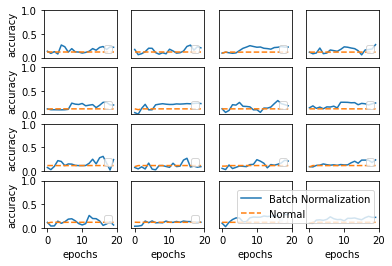

In [40]:
# batchnormalization test

x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, \
                 hidden_size_list=[100, 100, 100, 100, 100], output_size=10,\
                 weight_init_std=weight_init_std, use_batchnorm=True)
    
    network = MultiLayerNetExtend(input_size=784,\
              hidden_size_list=[100, 100, 100, 100, 100], output_size=10,\
              weight_init_std=weight_init_std)
    
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(10000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
            
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
            
            print("epoch:" + str(epoch_cnt) + "|" + str(train_acc) + " - " \
                 + str(bn_train_acc))
            
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list
    

import matplotlib.pyplot as plt
# グラフの描画
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print("====== " + str(i+1) + "/16" + " =====")
    train_acc_list, bn_train_acc_list = __train(w)
    print('train_acc_list', train_acc_list)
    print('bn_train_acc_list', bn_train_acc_list)
    
    plt.subplot(4, 4, i+1)
    #plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, \
                 label="Batch Normalization", markevery=2)
        plt.plot(x, train_acc_list, linestyle='--', label='Normal', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle='--', markevery=2)
    
    
    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel('epochs')
    plt.legend(loc='lower right')
    
plt.show()

In [41]:
# 過学習
# 大量のパラメータ
# 少ないデータ

import sys, os
import numpy as np
from mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


epoch:0, train acc:None, test acc:None
epoch:1, train acc:None, test acc:None
epoch:2, train acc:None, test acc:None
epoch:3, train acc:None, test acc:None
epoch:4, train acc:None, test acc:None
epoch:5, train acc:None, test acc:None
epoch:6, train acc:None, test acc:None
epoch:7, train acc:None, test acc:None
epoch:8, train acc:None, test acc:None
epoch:9, train acc:None, test acc:None
epoch:10, train acc:None, test acc:None
epoch:11, train acc:None, test acc:None
epoch:12, train acc:None, test acc:None
epoch:13, train acc:None, test acc:None
epoch:14, train acc:None, test acc:None
epoch:15, train acc:None, test acc:None
epoch:16, train acc:None, test acc:None
epoch:17, train acc:None, test acc:None
epoch:18, train acc:None, test acc:None
epoch:19, train acc:None, test acc:None
epoch:20, train acc:None, test acc:None
epoch:21, train acc:None, test acc:None
epoch:22, train acc:None, test acc:None
epoch:23, train acc:None, test acc:None
epoch:24, train acc:None, test acc:None
epoch:25, 

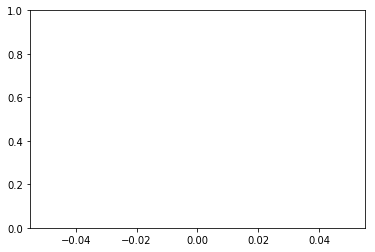

In [42]:
# 300個
x_train = x_train[:300]
t_train = t_train[:300]

weight_decay_lambda = 0
# weight_decay_lambda = 0.1

network = MultiLayerNet(input_size=784,
          hidden_size_list=[100, 100, 100, 100, 100, 100, 100],
          output_size=10,
          weight_decay_lambda=weight_decay_lambda)

optimizer = SGD(lr=0.01)
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)   
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))
    
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break
    
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, linestyle='--', marker='s', label='test', markevery=2)
plt.ylim(0, 1.0)
plt.show()

In [43]:
# DropOut

class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

epoch:0, train acc:0.08666666666666667, test acc:0.0718
epoch:1, train acc:0.09, test acc:0.066
epoch:2, train acc:0.07333333333333333, test acc:0.0822
epoch:3, train acc:0.08333333333333333, test acc:0.0949
epoch:4, train acc:0.09333333333333334, test acc:0.0826
epoch:5, train acc:0.08, test acc:0.0787
epoch:6, train acc:0.07333333333333333, test acc:0.0788
epoch:7, train acc:0.07666666666666666, test acc:0.0814
epoch:8, train acc:0.06666666666666667, test acc:0.078
epoch:9, train acc:0.07, test acc:0.0774
epoch:10, train acc:0.07666666666666666, test acc:0.0803
epoch:11, train acc:0.08, test acc:0.0779
epoch:12, train acc:0.07666666666666666, test acc:0.0756
epoch:13, train acc:0.07333333333333333, test acc:0.0798
epoch:14, train acc:0.08, test acc:0.0856
epoch:15, train acc:0.08, test acc:0.0858
epoch:16, train acc:0.08333333333333333, test acc:0.082
epoch:17, train acc:0.08333333333333333, test acc:0.0783
epoch:18, train acc:0.08666666666666667, test acc:0.0798
epoch:19, train acc:

epoch:151, train acc:0.10666666666666667, test acc:0.0966
epoch:152, train acc:0.10666666666666667, test acc:0.0956
epoch:153, train acc:0.10666666666666667, test acc:0.0964
epoch:154, train acc:0.10666666666666667, test acc:0.0965
epoch:155, train acc:0.10666666666666667, test acc:0.096
epoch:156, train acc:0.10666666666666667, test acc:0.0965
epoch:157, train acc:0.10666666666666667, test acc:0.0972
epoch:158, train acc:0.10666666666666667, test acc:0.0966
epoch:159, train acc:0.10666666666666667, test acc:0.0969
epoch:160, train acc:0.10666666666666667, test acc:0.0973
epoch:161, train acc:0.10666666666666667, test acc:0.0963
epoch:162, train acc:0.11, test acc:0.0981
epoch:163, train acc:0.1, test acc:0.0969
epoch:164, train acc:0.10333333333333333, test acc:0.0981
epoch:165, train acc:0.1, test acc:0.0977
epoch:166, train acc:0.09333333333333334, test acc:0.1
epoch:167, train acc:0.1, test acc:0.0996
epoch:168, train acc:0.09333333333333334, test acc:0.0994
epoch:169, train acc:0.

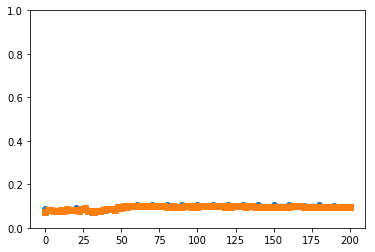

In [44]:
# Dropoutによる過学習の抑制

# 300個
x_train = x_train[:300]
t_train = t_train[:300]

weight_decay_lambda = 0
# weight_decay_lambda = 0.1

network = MultiLayerNetExtend(input_size=784,
          hidden_size_list=[100, 100, 100, 100, 100, 100, 100],
          output_size=10,
          weight_init_std='he',
          weight_decay_lambda=0,
          use_dropout=True,
          dropout_ration=0.5, 
          use_batchnorm=True)

optimizer = SGD(lr=0.01)
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)   
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))
    
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break
    
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, linestyle='--', marker='s', label='test', markevery=2)
plt.ylim(0, 1.0)
plt.show()

In [ ]:
# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = x_train.shape[0] * validation_rate

def shuffle_dataset(x, t):
    """データセットのシャッフルを行う

    Parameters
    ----------
    x : 訓練データ
    t : 教師データ

    Returns
    -------
    x, t : シャッフルを行った訓練データと教師データ
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list